# **Usando modelos pré-treinados no Keras para obter precisão RANK 1 e RANK 5**
1. Primeiro, carregaremos o modelo ImageNet pré-treinado MobileNetV2.
2. Obteremos as 5 principais classes a partir de uma única inferência de imagem.
3. Em seguida, construiremos uma função para nos fornecer a precisão de classificação N usando algumas imagens de teste.

In [16]:
from tensorflow.keras.applications.densenet import DenseNet201
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.densenet import preprocess_input, decode_predictions
import numpy as np

model = DenseNet201(weights='imagenet')
model.summary()

Model: "densenet201"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 230, 230,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 20,242,984 (77.22 MB)

 Trainable params: 20,013,928 (76.35 MB)

 Non-trainable params: 229,056 (894.75 KB)

In [17]:
import cv2
from os import listdir
from os.path import isfile, join

# Get images located in ./images folder    
mypath = "./images/class1/"
file_names = [f for f in listdir(mypath) if isfile(join(mypath, f))]
file_names

['1539714414867.jpg',
 '3040_e_41CT.jpg',
 '81z6x3SZEpL._AC_SL1500_.jpg',
 'Basketball_(Ball).jpg',
 'christmas-stockings-3006869_1280.jpg',
 'download.jpg',
 'German_Shepherd_-_DSC_0346_(10096362833).jpg',
 'limo-safety-ftr.jpg',
 'long-haired-collie-5766447_1280.jpg',
 'photo-1575361204480-aadea25e6e68.jpg',
 'spiderweb_1050x700.jpg']

1/1 ━━━━━━━━━━━━━━━━━━━━ 20s 20s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


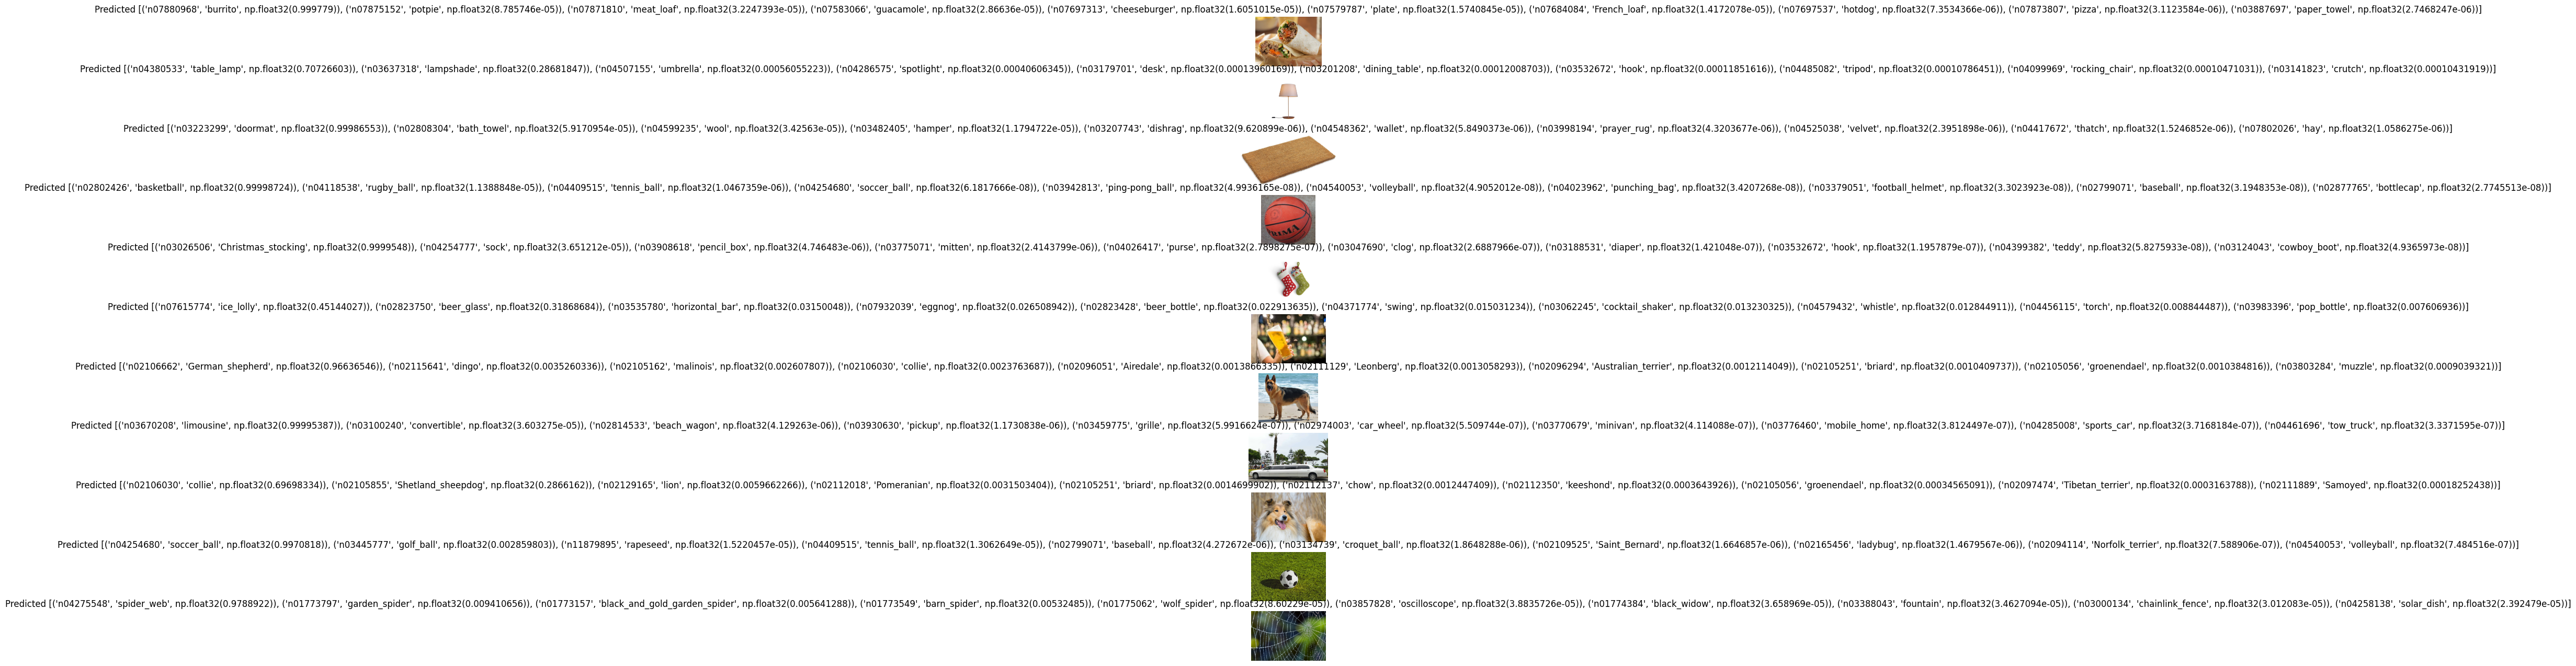

In [18]:
import matplotlib.pyplot as plt

fig=plt.figure(figsize=(16,16))
all_top_classes = []

# Loop through images run them through our classifer
for (i,file) in enumerate(file_names):

    img = image.load_img(mypath+file, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    
    #load image using opencv
    img2 = cv2.imread(mypath+file)
    #imageL = cv2.resize(img2, None, fx=.5, fy=.5, interpolation = cv2.INTER_CUBIC) 
    
    # Get Predictions
    preds = model.predict(x)
    preditions = decode_predictions(preds, top=10)[0]
    all_top_classes.append([x[1] for x in preditions])
    # Plot image
    sub = fig.add_subplot(len(file_names),1, i+1)
    sub.set_title(f'Predicted {str(preditions)}')
    plt.axis('off')
    plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))

plt.show()

In [19]:
preditions

[('n04275548', 'spider_web', np.float32(0.9788922)),
 ('n01773797', 'garden_spider', np.float32(0.009410656)),
 ('n01773157', 'black_and_gold_garden_spider', np.float32(0.005641288)),
 ('n01773549', 'barn_spider', np.float32(0.00532485)),
 ('n01775062', 'wolf_spider', np.float32(8.60229e-05)),
 ('n03857828', 'oscilloscope', np.float32(3.8835726e-05)),
 ('n01774384', 'black_widow', np.float32(3.658969e-05)),
 ('n03388043', 'fountain', np.float32(3.4627094e-05)),
 ('n03000134', 'chainlink_fence', np.float32(3.012083e-05)),
 ('n04258138', 'solar_dish', np.float32(2.392479e-05))]

In [20]:
all_top_classes

[['burrito',
  'potpie',
  'meat_loaf',
  'guacamole',
  'cheeseburger',
  'plate',
  'French_loaf',
  'hotdog',
  'pizza',
  'paper_towel'],
 ['table_lamp',
  'lampshade',
  'umbrella',
  'spotlight',
  'desk',
  'dining_table',
  'hook',
  'tripod',
  'rocking_chair',
  'crutch'],
 ['doormat',
  'bath_towel',
  'wool',
  'hamper',
  'dishrag',
  'wallet',
  'prayer_rug',
  'velvet',
  'thatch',
  'hay'],
 ['basketball',
  'rugby_ball',
  'tennis_ball',
  'soccer_ball',
  'ping-pong_ball',
  'volleyball',
  'punching_bag',
  'football_helmet',
  'baseball',
  'bottlecap'],
 ['Christmas_stocking',
  'sock',
  'pencil_box',
  'mitten',
  'purse',
  'clog',
  'diaper',
  'hook',
  'teddy',
  'cowboy_boot'],
 ['ice_lolly',
  'beer_glass',
  'horizontal_bar',
  'eggnog',
  'beer_bottle',
  'swing',
  'cocktail_shaker',
  'whistle',
  'torch',
  'pop_bottle'],
 ['German_shepherd',
  'dingo',
  'malinois',
  'collie',
  'Airedale',
  'Leonberg',
  'Australian_terrier',
  'briard',
  'groenen

In [21]:
len(all_top_classes[0])

10

In [33]:
ground_truth = ['burrito',
                 'table lamp',
                 'bath towel',
                'basketball',
                'Christmas_stocking',
                'beer_glass',
                'German_shepherd',
                'limousine',
                'collie',
                'soccer_ball',
               "spider_web",
              
               ]

In [34]:
def getScore(all_top_classes, ground_truth, N):
  # Calcuate rank-N score
  in_labels = 0
  for (i,labels) in enumerate(all_top_classes):
    if ground_truth[i] in labels[:N]:
      in_labels += 1
  return f'Rank-{N} Accuracy = {in_labels/len(all_top_classes)*100:.2f}%'

# PEGANDO O RANK-5 

In [36]:
getScore(all_top_classes, ground_truth, 10)

'Rank-1 Accuracy = 72.73%'